# Summary

In this project, I perform funnel analysis for an e-commerce website, which consists of four stages:

* home page
* search and item page
* cart page (requires payment info)
* order page (payment confirmation)

in three aspects:
* funnel conversion rate for different devices (desktop/mobile) and genders
* study the impacts of genders
* build an XGBoost model with SMOTE oversampling to predict whether a user will put an order, and plot the feature importance

### import libraries

In [1]:
# %%capture
# !pip install sklearn imblearn --upgrade

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from feature_engine import encoding as ce
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# because the class is imbalanced
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imbPipeline

from collections import Counter

### load data

In [4]:
home_df = pd.read_csv('./data/home_page_table.csv')
search_df = pd.read_csv('./data/search_page_table.csv')
cart_df = pd.read_csv('./data/payment_page_table.csv')
order_df = pd.read_csv('./data/payment_confirmation_table.csv')

print(f'home page row number {len(home_df)}')
display(home_df.head())
display(search_df.head())

home page row number 90400


,user_id,page
0,313593,home_page
1,468315,home_page
2,264005,home_page
3,290784,home_page
4,639104,home_page


,user_id,page
0,15866,search_page
1,347058,search_page
2,577020,search_page
3,780347,search_page
4,383739,search_page


In [5]:
user_df = pd.read_csv('./data/user_table.csv', parse_dates=['date'])
print(f'Total row number {len(user_df)}; Unique user id number {len(set(user_df.user_id))}')
user_df.head()

Total row number 90400; Unique user id number 90400


,user_id,date,device,sex
0,450007,2015-02-28,Desktop,Female
1,756838,2015-01-13,Desktop,Male
2,568983,2015-04-09,Desktop,Male
3,190794,2015-02-18,Desktop,Female
4,537909,2015-01-15,Desktop,Male


#### From the last cell we know there is no duplicated user_id. So we merge all data frames into funnel_df.

In [6]:
num2page = {0:'home', 1:'search', 2:'cart', 3:'order',}

funnel_df = pd.read_csv('./data/user_table.csv', parse_dates=['date'],index_col="user_id")
funnel_df.loc[home_df.user_id, "final_step"] = 0
funnel_df.loc[search_df.user_id, "final_step"] = 1
funnel_df.loc[cart_df.user_id, "final_step"] = 2
funnel_df.loc[order_df.user_id, "final_step"] = 3
funnel_df['final_page'] = funnel_df.final_step.map(num2page)
funnel_df['weekday'] = funnel_df.date.dt.day_of_week
funnel_df.head()

,date,device,sex,final_step,final_page,weekday
user_id,,,,,,
450007,2015-02-28,Desktop,Female,0.0,home,5
756838,2015-01-13,Desktop,Male,0.0,home,1
568983,2015-04-09,Desktop,Male,1.0,search,3
190794,2015-02-18,Desktop,Female,1.0,search,2
537909,2015-01-15,Desktop,Male,0.0,home,3


### Analyze the conversion rates

In [7]:
def conversion_analysis(df):
    # how many users have reached this step
    reach_step_counts = pd.DataFrame([(df.final_step>=num).sum() for num in range(4)], columns=['n'])

    # how many users stop at this step
    stop_step_counts = -reach_step_counts.diff().shift(-1)
    stop_step_counts.loc[3] = reach_step_counts.loc[3]
    stop_step_counts = stop_step_counts.astype(int)

    output_df = pd.concat([reach_step_counts.n, stop_step_counts.n], axis=1, keys=["n_reach", "n_stop",])
    output_df["n_convert"] = output_df.n_reach - output_df.n_stop
    output_df["convert_rate"] = output_df.n_convert/output_df.n_reach
    output_df['stop_rates'] = 1 - output_df.convert_rate
    output_df["page"] = output_df.index.map(num2page)
    output_df = output_df[["page"] + list(output_df.columns)[:-1]]
    
    return output_df

device_funnel_df = funnel_df.groupby('device').apply(conversion_analysis)

print('The overview of funnel data grouped by device:')
device_funnel_df

The overview of funnel data grouped by device:


page  n_reach  n_stop  n_convert  convert_rate  stop_rates
device                                                                 
Desktop 0    home    60200   30100      30100      0.500000    0.500000
        1  search    30100   27090       3010      0.100000    0.900000
        2    cart     3010    2860        150      0.049834    0.950166
        3   order      150     150          0      0.000000    1.000000
Mobile  0    home    30200   15100      15100      0.500000    0.500000
        1  search    15100   12080       3020      0.200000    0.800000
        2    cart     3020    2718        302      0.100000    0.900000
        3   order      302     302          0      0.000000    1.000000

In [8]:
device_stop_df = funnel_df.groupby('device')['final_page'].apply(lambda s: s.value_counts(normalize=True)).unstack()
print('The ratio of pages where users stop from different devices:')
device_stop_df

The ratio of pages where users stop from different devices:


,home,search,cart,order
device,,,,
Desktop,0.5,0.45,0.047508,0.002492
Mobile,0.5,0.40,0.090000,0.010000


<Figure size 720x432 with 0 Axes>

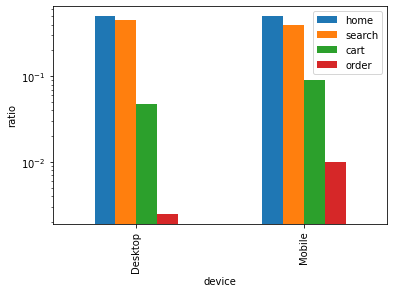

In [9]:
plt.figure(figsize=(10, 6))
device_stop_df.plot.bar()
plt.ylabel('ratio')
plt.gca().set_yscale('log')

In [10]:
gender_stop_df = funnel_df.groupby('sex')['final_page'].apply(lambda s: s.value_counts(normalize=True)).unstack()
print('The ratio of pages where users stop from different genders:')
gender_stop_df

The ratio of pages where users stop from different genders:


,home,search,cart,order
sex,,,,
Female,0.496927,0.434298,0.063428,0.005347
Male,0.503056,0.432300,0.059989,0.004655


<Figure size 720x432 with 0 Axes>

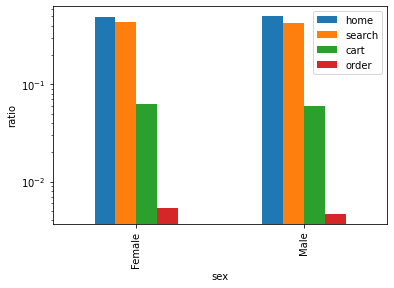

In [11]:
plt.figure(figsize=(10, 6))
gender_stop_df.plot.bar()
plt.ylabel('ratio')
plt.gca().set_yscale('log')

### order prediction

build an XGBoost model with SMOTE oversampling to predict whether a user will put an order, and plot the feature importance

The model reached AUC score of 0.68, which is decent given the limited information.

In [15]:
X = funnel_df[['device', 'sex', 'weekday']].astype(str)
y = (funnel_df['final_step']==3).astype(int)
print(X.shape, y.shape)

(90400, 3) (90400,)


In [16]:
# split the training set into train/val split for local validation
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42)

In [17]:
XGB_pipe = imbPipeline([
    ('cat_encoding', ce.OneHotEncoder(variables=list(X.columns))),
    ("oversampling", SMOTE(sampling_strategy='auto', random_state=42)),
    ('XGB', XGBClassifier(random_state=42))
    ])

XGB_pipe.fit(X_train, y_train)
val_prediction = XGB_pipe.predict(X_val)
XGB_df = pd.DataFrame({'Accuracy': accuracy_score(y_val, val_prediction),
                        'ROC-AUC Score': roc_auc_score(y_val, val_prediction)}, index=['GBM'])
display(XGB_df)

D:\System_Support\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:36:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Accuracy,ROC-AUC Score
GBM,0.671903,0.675221


,correct,incorrect,class-recall
leave,12091,5905,67.2
order,57,27,67.9


Text(0.5, 0, 'ground truth class')

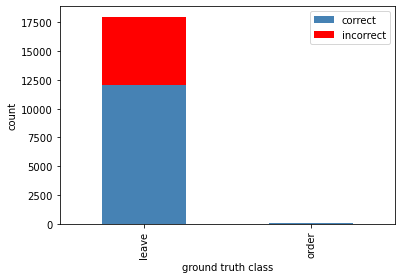

In [18]:
perform_count = Counter(list(zip(y_val, val_prediction)))
perform_df = pd.DataFrame({'correct': [perform_count[(0,0)],perform_count[(1,1)]],
                          'incorrect': [perform_count[(0,1)],perform_count[(1,0)]],}, 
                         index=['leave','order', ])
perform_df.plot(kind='bar', stacked=True, color=['steelblue', 'red'])
perform_df['class-recall'] = (100*perform_df['correct']/(perform_df['correct']+perform_df['incorrect'])).round(1)
display(perform_df)
plt.ylabel('count')
plt.xlabel('ground truth class')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

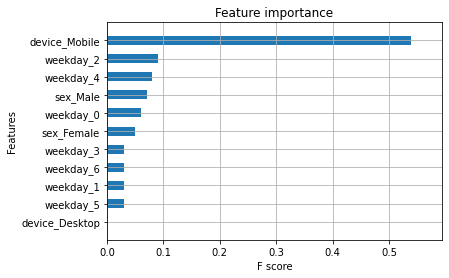

In [19]:
feature2importance = dict(zip(
    XGB_pipe['cat_encoding'].transform(X_train).columns.values,
    XGB_pipe['XGB'].feature_importances_.round(2),
))

fig, ax = plt.subplots(1, 1, figsize=(6,4))
plot_importance(feature2importance, ax=ax, height=0.5, max_num_features=15,
               importance_type='gain', show_values=False)